**Lab 5** \\
How to get the most out of your data

In [5]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import xgboost
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

In [6]:
X = pd.read_parquet('X.parquet')
y = pd.read_parquet('y.parquet')
base = pd.read_parquet('base_data.parquet')

In [7]:
x_col = list(X.columns)
base_col = list(base.columns)
duplicated_columns = [col for col in base_col if col in x_col]
base.drop(columns=duplicated_columns, inplace=True)
panel=pd.concat([X, base, y], axis=1)
small_panel = panel[['quote_date', 'equipment_type', 'direct_mileage', 'source_price']]

small_panel['year'] = small_panel['quote_date'].dt.year
small_panel['month'] = small_panel['quote_date'].dt.month
small_panel['day'] = small_panel['quote_date'].dt.day

small_panel['date'] = small_panel['year'].astype(str) + '-' + small_panel['month'].astype(str) + '-' + small_panel['day'].astype(str)
small_panel['date'] = pd.to_datetime(small_panel['date'], format='%Y-%m-%d')

agg_date = small_panel[['date', 'direct_mileage', 'source_price']].groupby('date').sum().reset_index()
agg_date['rate'] =  agg_date['source_price'] / agg_date['direct_mileage']

<ipython-input-7-e5f025dcac00>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_panel['year'] = small_panel['quote_date'].dt.year
<ipython-input-7-e5f025dcac00>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_panel['month'] = small_panel['quote_date'].dt.month
<ipython-input-7-e5f025dcac00>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

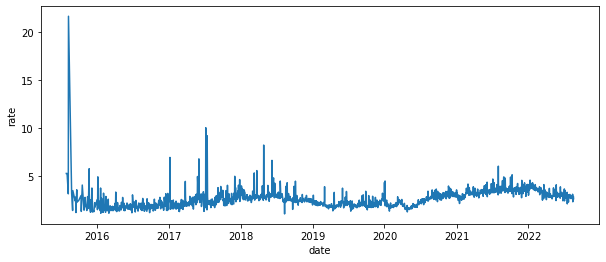

In [8]:
sns.lineplot(data=agg_date, x='date', y='rate')
fig = plt.gcf()
fig.set_size_inches(10, 4)

In [9]:
agg_date['rate'].mean()

2.6461573334575923

In [10]:
agg_date['rate'].quantile(0.01)

1.3566029900845635

In [11]:
agg_date['rate'].quantile(0.99)

4.724501878629681

In [12]:
agg_date['rate'].mask((agg_date['rate'] < agg_date['rate'].quantile(0.01)) |
                      (agg_date['rate'] > agg_date['rate'].quantile(0.99)), pd.NA).isna().sum()

44

In [13]:
agg_date['rate'] = agg_date['rate'].mask((agg_date['rate'] < agg_date['rate'].quantile(0.01)) |
                      (agg_date['rate'] > agg_date['rate'].quantile(0.99)), agg_date['rate'].mean())


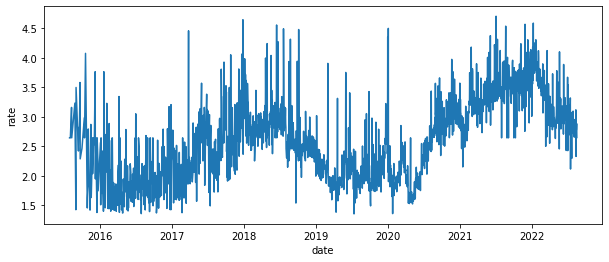

In [14]:
sns.lineplot(data=agg_date, x='date', y='rate')
fig = plt.gcf()
fig.set_size_inches(10, 4)

In [15]:
agg_date.drop(columns=['direct_mileage', 'source_price'], inplace=True)

In [16]:
agg_date

,date,rate
0,2015-07-31,2.646157
1,2015-08-04,2.646157
2,2015-08-10,3.161765
3,2015-08-11,2.646157
4,2015-08-27,3.234501
...,...,...
2177,2022-08-14,2.331696
2178,2022-08-15,2.767279
2179,2022-08-16,2.791936
2180,2022-08-17,2.886730


In [17]:
agg_date['year'] = agg_date['date'].dt.year
agg_date['month'] = agg_date['date'].dt.month
agg_date['day'] = agg_date['date'].dt.day
agg_date['weekday'] = agg_date['date'].dt.weekday

In [18]:
agg_date

,date,rate,year,month,day,weekday
0,2015-07-31,2.646157,2015,7,31,4
1,2015-08-04,2.646157,2015,8,4,1
2,2015-08-10,3.161765,2015,8,10,0
3,2015-08-11,2.646157,2015,8,11,1
4,2015-08-27,3.234501,2015,8,27,3
...,...,...,...,...,...,...
2177,2022-08-14,2.331696,2022,8,14,6
2178,2022-08-15,2.767279,2022,8,15,0
2179,2022-08-16,2.791936,2022,8,16,1
2180,2022-08-17,2.886730,2022,8,17,2


In [19]:
agg_date.columns

Index(['date', 'rate', 'year', 'month', 'day', 'weekday'], dtype='object')

In [20]:
train = agg_date[agg_date['date'] < '2021-01-01']
test = agg_date[agg_date['date'] >= '2021-01-01']
X_train, y_train = train[['year', 'month', 'day', 'weekday']], train[['rate']]
X_test, y_test = test[['year', 'month', 'day', 'weekday']], test[['rate']]
clf = LinearRegression()
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

mse = mean_squared_error(test['rate'], pred)
rmse = mean_squared_error(test['rate'], pred, squared=False)
mape = mean_absolute_percentage_error(test['rate'], pred)
table = pd.DataFrame({'MSE':[mse], 'RMSE':[rmse], 'MAPE':[mape]})
table

,MSE,RMSE,MAPE
0,0.929654,0.964186,0.252937


In [21]:
clf.coef_
clf.intercept_

array([-87.40470808])

In [40]:
fuel = pd.read_excel('fuel_data.xls', sheet_name='Data 1', header=2)

In [41]:
fuel = fuel[['Date', 'Weekly U.S. No 2 Diesel Retail Prices  (Dollars per Gallon)']].dropna()

In [42]:
fuel.rename(columns={'Weekly U.S. No 2 Diesel Retail Prices  (Dollars per Gallon)':'fuel price'}, inplace=True)

In [43]:
fuel

,Date,fuel price
187,1994-03-21,1.106
188,1994-03-28,1.107
189,1994-04-04,1.109
190,1994-04-11,1.108
191,1994-04-18,1.105
...,...,...
1691,2023-01-16,4.524
1692,2023-01-23,4.604
1693,2023-01-30,4.622
1694,2023-02-06,4.539


In [44]:
agg_date['RP'] = agg_date['year'].astype(str) + '-' + agg_date['month'].astype(str)
agg_date['RP'] = pd.to_datetime(agg_date['RP'], format='%Y-%m')

In [45]:
agg_date

,date,rate,year,month,day,weekday,RP
0,2015-07-31,2.646157,2015,7,31,4,2015-07-01
1,2015-08-04,2.646157,2015,8,4,1,2015-08-01
2,2015-08-10,3.161765,2015,8,10,0,2015-08-01
3,2015-08-11,2.646157,2015,8,11,1,2015-08-01
4,2015-08-27,3.234501,2015,8,27,3,2015-08-01
...,...,...,...,...,...,...,...
2177,2022-08-14,2.331696,2022,8,14,6,2022-08-01
2178,2022-08-15,2.767279,2022,8,15,0,2022-08-01
2179,2022-08-16,2.791936,2022,8,16,1,2022-08-01
2180,2022-08-17,2.886730,2022,8,17,2,2022-08-01


In [46]:
fuel['year'] = fuel['Date'].dt.year
fuel['month'] = fuel['Date'].dt.month
fuel['RP'] = fuel['year'].astype(str) + '-' + fuel['month'].astype(str)
fuel['RP'] = pd.to_datetime(fuel['RP'], format='%Y-%m')
fuel.drop(columns=['year', 'month', 'Date'], inplace=True)
fuel = fuel.groupby(by='RP').mean()

In [47]:
fuel

,fuel price
RP,
1994-03-01,1.10650
1994-04-01,1.10700
1994-05-01,1.10020
1994-06-01,1.10250
1994-07-01,1.11025
...,...
2022-10-01,5.21140
2022-11-01,5.25500
2022-12-01,4.71350


In [48]:
fuel['fuel price lag 1'] = fuel['fuel price'].shift(1)

In [49]:
fuel1 = fuel.copy()

In [50]:
agg_date = agg_date.join(fuel, on='RP', how='left')


In [51]:
agg_date.drop(columns=['RP', 'fuel price'], inplace=True)

<AxesSubplot:xlabel='date'>

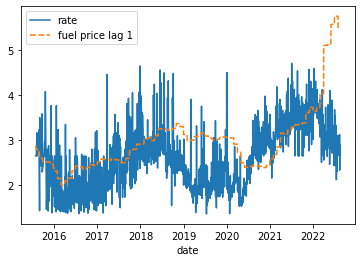

In [52]:
sns.lineplot(data=agg_date[['date', 'rate', 'fuel price lag 1']].set_index('date'))

In [53]:
agg_date[['rate', 'fuel price lag 1']].corr()

,rate,fuel price lag 1
rate,1.000000,0.386465
fuel price lag 1,0.386465,1.000000


In [54]:
agg_date

,date,rate,year,month,day,weekday,fuel price lag 1
0,2015-07-31,2.646157,2015,7,31,4,2.87300
1,2015-08-04,2.646157,2015,8,4,1,2.78775
2,2015-08-10,3.161765,2015,8,10,0,2.78775
3,2015-08-11,2.646157,2015,8,11,1,2.78775
4,2015-08-27,3.234501,2015,8,27,3,2.78775
...,...,...,...,...,...,...,...
2177,2022-08-14,2.331696,2022,8,14,6,5.48575
2178,2022-08-15,2.767279,2022,8,15,0,5.48575
2179,2022-08-16,2.791936,2022,8,16,1,5.48575
2180,2022-08-17,2.886730,2022,8,17,2,5.48575


In [55]:
train = agg_date[agg_date['date'] < '2021-01-01']
test = agg_date[agg_date['date'] >= '2021-01-01']
X_train, y_train = train[['year', 'month', 'day', 'weekday', 'fuel price lag 1']], train[['rate']]
X_test, y_test = test[['year', 'month', 'day', 'weekday', 'fuel price lag 1']], test[['rate']]
clf =  LinearRegression()
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

mse = mean_squared_error(test['rate'], pred)
rmse = mean_squared_error(test['rate'], pred, squared=False)
mape = mean_absolute_percentage_error(test['rate'], pred)
table = pd.DataFrame({'MSE':[mse], 'RMSE':[rmse], 'MAPE':[mape]})
table

,MSE,RMSE,MAPE
0,0.783429,0.885115,0.220244


In [56]:
from pandas.tseries.holiday import USFederalHolidayCalendar

In [57]:
cal = USFederalHolidayCalendar()
holidays = list(cal.holidays(start=agg_date['date'].min(), end=agg_date['date'].max()).to_pydatetime())

In [58]:
agg_date['holiday'] = agg_date['date'].isin(holidays).astype(int)

In [59]:
agg_date[['rate', 'holiday']].groupby('holiday').mean()

,rate
holiday,
0,2.615780
1,2.768814


In [60]:
train = agg_date[agg_date['date'] < '2021-01-01']
test = agg_date[agg_date['date'] >= '2021-01-01']
X_train, y_train = train[['year', 'month', 'day', 'weekday', 'fuel price lag 1', 'holiday']], train[['rate']]
X_test, y_test = test[['year', 'month', 'day', 'weekday', 'fuel price lag 1', 'holiday']], test[['rate']]
clf =  LinearRegression()
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

mse = mean_squared_error(test['rate'], pred)
rmse = mean_squared_error(test['rate'], pred, squared=False)
mape = mean_absolute_percentage_error(test['rate'], pred)
table = pd.DataFrame({'MSE':[mse], 'RMSE':[rmse], 'MAPE':[mape]})
table

,MSE,RMSE,MAPE
0,0.784043,0.885462,0.220443


In [61]:
agg_date['weekend'] = agg_date['weekday'].isin([6,7]).astype(int)

In [62]:
agg_date = agg_date.set_index('date')

In [63]:
train = agg_date[agg_date.index < '2021-01-01']
test = agg_date[agg_date.index >= '2021-01-01']
X_train, y_train = train[['year', 'month', 'day', 'weekday', 'fuel price lag 1', 'holiday', 'weekend']], train[['rate']]
X_test, y_test = test[['year', 'month', 'day', 'weekday', 'fuel price lag 1', 'holiday', 'weekend']], test[['rate']]
clf =  LinearRegression()
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

mse = mean_squared_error(test['rate'], pred)
rmse = mean_squared_error(test['rate'], pred, squared=False)
mape = mean_absolute_percentage_error(test['rate'], pred)
table = pd.DataFrame({'MSE':[mse], 'RMSE':[rmse], 'MAPE':[mape]})
table

,MSE,RMSE,MAPE
0,0.784066,0.885475,0.220469


In [64]:
clf.coef_

array([[0.02800665, 0.03383698, 0.00148142, 0.02049151, 0.18665214,
        0.05936999, 0.00536597]])

<AxesSubplot:xlabel='date agg'>

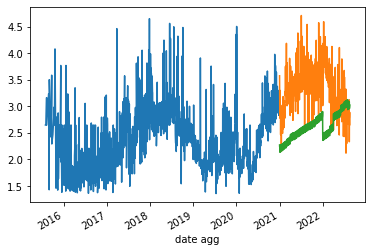

In [65]:
prediction = pd.DataFrame()
prediction['date agg'] = y_test.index
prediction['rate'] = pred
prediction.set_index('date agg', inplace=True)
train['rate'].plot()
test['rate'].plot()
prediction['rate'].plot()

In [66]:
agg_date['MA(7)'] = agg_date['rate'].rolling(7).mean()
agg_date['MA(7) laged'] = agg_date['MA(7)'].shift(7)

In [67]:
del agg_date['MA(7)']

In [68]:
agg_date.dropna(inplace=True)

In [69]:
train = agg_date[agg_date.index < '2021-01-01']
test = agg_date[agg_date.index >= '2021-01-01']
X_train, y_train = train[['year', 'month', 'day', 'weekday', 'fuel price lag 1', 'holiday', 'weekend', 'MA(7) laged']], train[['rate']]
X_test, y_test = test[['year', 'month', 'day', 'weekday', 'fuel price lag 1', 'holiday', 'weekend', 'MA(7) laged']], test[['rate']]
clf =  LinearRegression()
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

mse = mean_squared_error(test['rate'], pred)
rmse = mean_squared_error(test['rate'], pred, squared=False)
mape = mean_absolute_percentage_error(test['rate'], pred)
table = pd.DataFrame({'MSE':[mse], 'RMSE':[rmse], 'MAPE':[mape]})
table

,MSE,RMSE,MAPE
0,0.11355,0.336972,0.074433


<AxesSubplot:xlabel='date agg'>

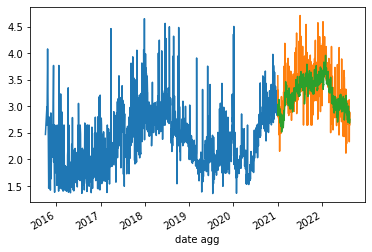

In [70]:
prediction = pd.DataFrame()
prediction['date agg'] = y_test.index
prediction['rate'] = pred
prediction.set_index('date agg', inplace=True)
train['rate'].plot()
test['rate'].plot()
prediction['rate'].plot()

In [71]:
clf.coef_

array([[ 0.00533881,  0.01207354,  0.00229299,  0.02269584,  0.00181586,
        -0.01084905,  0.09013115,  0.83927462]])

In [72]:
pred = test[['MA(7) laged']]
mse = mean_squared_error(test['rate'], pred)
rmse = mean_squared_error(test['rate'], pred, squared=False)
mape = mean_absolute_percentage_error(test['rate'], pred)
table = pd.DataFrame({'MSE':[mse], 'RMSE':[rmse], 'MAPE':[mape]})
table

,MSE,RMSE,MAPE
0,0.09496,0.308156,0.067161


In [73]:
del fuel['fuel price lag 1']

**In-class activity**  \\
Ok, it didn't work with the rate, but could we forecast diesel prices?
1. Use the "fuel" dataframe and create time-related features. The minimum to consider includes year, month, and day of the week. Check if you can make accurate predictions with them. Whenever you train and test the models, don't forget to split data. Please, reserve the last 12 months for the test. It is up to you which model to use, but I would stay with something linear like linear regression or lasso regression.
2. The exogenous variables may be helpful. You can use some of those that I provided below (unemployment, cpi, oil price) or come up with your own. The variables may require additional aggregation and imputation of missing values (you can impute with average). Don't forget to lag them by one month to prevent data leakage. Did it help to improve the accuracy? 
3. What will happen if you use a 7-days moving average as a variable (lagged by 7 days). Will it help to improve the accuracy? How about the moving average alone? Does it perform better? 

In [74]:
#dataframe to start with 
fuel1 = fuel.copy()
fuel1

,fuel price
RP,
1994-03-01,1.10650
1994-04-01,1.10700
1994-05-01,1.10020
1994-06-01,1.10250
1994-07-01,1.11025
...,...
2022-10-01,5.21140
2022-11-01,5.25500
2022-12-01,4.71350


In [75]:
#fuel1.reset_index(inplace=True)
#fuel1.rename(columns={'RP':'Date'}, inplace=True)

#fuel1.set_index(['Date'])
fuel1

,fuel price
RP,
1994-03-01,1.10650
1994-04-01,1.10700
1994-05-01,1.10020
1994-06-01,1.10250
1994-07-01,1.11025
...,...
2022-10-01,5.21140
2022-11-01,5.25500
2022-12-01,4.71350


In [77]:
!pip install quandl
import quandl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [78]:
unemployment = pd.DataFrame(quandl.get("FRED/UNRATE", start_date=fuel.index.min(), end_date=fuel.index.max()))
cpi = pd.DataFrame(quandl.get("RATEINF/CPI_USA", start_date=fuel.index.min(), end_date=fuel.index.max()))
brent_oil = pd.DataFrame(quandl.get("FRED/DCOILBRENTEU", start_date=fuel.index.min(), end_date=fuel.index.max()))

In [79]:
unemployment

,Value
Date,
1994-03-01,6.5
1994-04-01,6.4
1994-05-01,6.1
1994-06-01,6.1
1994-07-01,6.1
...,...
2021-09-01,4.7
2021-10-01,4.6
2021-11-01,4.2


In [80]:
unemployment.rename(columns={'Value':'enemp'}, inplace=True)
cpi.rename(columns={'Value':'cpi'}, inplace=True)
brent_oil.rename(columns={'Value':'brent'}, inplace=True)

In [81]:
brent_oil

,brent
Date,
1994-03-01,13.45
1994-03-02,13.50
1994-03-03,13.55
1994-03-04,13.43
1994-03-07,13.13
...,...
2022-05-17,112.89
2022-05-18,110.04
2022-05-19,113.22


In [82]:
unemployment['unemp lag 1'] = unemployment['enemp'].shift(1) #maybe i will know only yesterday price today
cpi['cpi lag 1'] = cpi['cpi'].shift(1)
brent_oil['brent lag 1'] = brent_oil['brent'].shift(1)

In [83]:
cpi

,cpi,cpi lag 1
Date,,
1994-03-31,147.200,NaN
1994-04-30,147.400,147.200
1994-05-31,147.500,147.400
1994-06-30,148.000,147.500
1994-07-31,148.400,148.000
...,...,...
2022-09-30,296.808,296.171
2022-10-31,298.012,296.808
2022-11-30,297.711,298.012


In [84]:
fuel1 = fuel1.join(unemployment, on='RP', how='left')

In [85]:
fuel1

,fuel price,enemp,unemp lag 1
RP,,,
1994-03-01,1.10650,6.5,NaN
1994-04-01,1.10700,6.4,6.5
1994-05-01,1.10020,6.1,6.4
1994-06-01,1.10250,6.1,6.1
1994-07-01,1.11025,6.1,6.1
...,...,...,...
2022-10-01,5.21140,NaN,NaN
2022-11-01,5.25500,NaN,NaN
2022-12-01,4.71350,NaN,NaN


In [86]:
fuel1.dropna(inplace=True)

In [87]:
fuel1

,fuel price,enemp,unemp lag 1
RP,,,
1994-04-01,1.10700,6.4,6.5
1994-05-01,1.10020,6.1,6.4
1994-06-01,1.10250,6.1,6.1
1994-07-01,1.11025,6.1,6.1
1994-08-01,1.12320,6.0,6.1
...,...,...,...
2021-09-01,3.38400,4.7,5.2
2021-10-01,3.61175,4.6,4.7
2021-11-01,3.72700,4.2,4.6


In [88]:
brent_oil

,brent,brent lag 1
Date,,
1994-03-01,13.45,NaN
1994-03-02,13.50,13.45
1994-03-03,13.55,13.50
1994-03-04,13.43,13.55
1994-03-07,13.13,13.43
...,...,...
2022-05-17,112.89,114.86
2022-05-18,110.04,112.89
2022-05-19,113.22,110.04


In [89]:
fuel1 = fuel1.join(brent_oil, on='RP', how='left')

In [90]:
fuel1

,fuel price,enemp,unemp lag 1,brent,brent lag 1
RP,,,,,
1994-04-01,1.10700,6.4,6.5,NaN,NaN
1994-05-01,1.10020,6.1,6.4,NaN,NaN
1994-06-01,1.10250,6.1,6.1,16.40,16.18
1994-07-01,1.11025,6.1,6.1,17.65,17.45
1994-08-01,1.12320,6.0,6.1,19.03,18.48
...,...,...,...,...,...
2021-09-01,3.38400,4.7,5.2,71.99,73.45
2021-10-01,3.61175,4.6,4.7,79.40,77.81
2021-11-01,3.72700,4.2,4.6,84.51,83.10


In [91]:
fuel1.dropna(inplace=True)

In [92]:
fuel1

,fuel price,enemp,unemp lag 1,brent,brent lag 1
RP,,,,,
1994-06-01,1.10250,6.1,6.1,16.40,16.18
1994-07-01,1.11025,6.1,6.1,17.65,17.45
1994-08-01,1.12320,6.0,6.1,19.03,18.48
1994-09-01,1.12500,5.9,6.0,16.03,16.03
1994-11-01,1.13100,5.6,5.8,17.40,17.18
...,...,...,...,...,...
2021-07-01,3.33875,5.4,5.9,76.69,76.94
2021-09-01,3.38400,4.7,5.2,71.99,73.45
2021-10-01,3.61175,4.6,4.7,79.40,77.81


In [93]:
cpi

,cpi,cpi lag 1
Date,,
1994-03-31,147.200,NaN
1994-04-30,147.400,147.200
1994-05-31,147.500,147.400
1994-06-30,148.000,147.500
1994-07-31,148.400,148.000
...,...,...
2022-09-30,296.808,296.171
2022-10-31,298.012,296.808
2022-11-30,297.711,298.012


In [97]:
cpi.to_csv('cpi.csv')
fuel1.to_csv('fuel1.csv')

In [98]:
fuel1

,fuel price,enemp,unemp lag 1,brent,brent lag 1
RP,,,,,
1994-06-01,1.10250,6.1,6.1,16.40,16.18
1994-07-01,1.11025,6.1,6.1,17.65,17.45
1994-08-01,1.12320,6.0,6.1,19.03,18.48
1994-09-01,1.12500,5.9,6.0,16.03,16.03
1994-11-01,1.13100,5.6,5.8,17.40,17.18
...,...,...,...,...,...
2021-07-01,3.33875,5.4,5.9,76.69,76.94
2021-09-01,3.38400,4.7,5.2,71.99,73.45
2021-10-01,3.61175,4.6,4.7,79.40,77.81


In [99]:
fuel1.dropna(inplace=True)

In [100]:
fuel1

,fuel price,enemp,unemp lag 1,brent,brent lag 1
RP,,,,,
1994-06-01,1.10250,6.1,6.1,16.40,16.18
1994-07-01,1.11025,6.1,6.1,17.65,17.45
1994-08-01,1.12320,6.0,6.1,19.03,18.48
1994-09-01,1.12500,5.9,6.0,16.03,16.03
1994-11-01,1.13100,5.6,5.8,17.40,17.18
...,...,...,...,...,...
2021-07-01,3.33875,5.4,5.9,76.69,76.94
2021-09-01,3.38400,4.7,5.2,71.99,73.45
2021-10-01,3.61175,4.6,4.7,79.40,77.81


In [101]:
fuel1.reset_index(inplace=True)

In [102]:
fuel1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212 entries, 0 to 211
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   RP           212 non-null    datetime64[ns]
 1   fuel price   212 non-null    float64       
 2   enemp        212 non-null    float64       
 3   unemp lag 1  212 non-null    float64       
 4   brent        212 non-null    float64       
 5   brent lag 1  212 non-null    float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 10.1 KB


In [103]:
fuel1.dtypes

RP             datetime64[ns]
fuel price            float64
enemp                 float64
unemp lag 1           float64
brent                 float64
brent lag 1           float64
dtype: object

In [104]:
fuel1['year'] = fuel1['RP'].dt.year
fuel1['month'] = fuel1['RP'].dt.month
fuel1['day'] = fuel1['RP'].dt.day
fuel1['weekday'] = fuel1['RP'].dt.weekday

In [105]:
fuel1

,RP,fuel price,enemp,unemp lag 1,brent,brent lag 1,year,month,day,weekday
0,1994-06-01,1.10250,6.1,6.1,16.40,16.18,1994,6,1,2
1,1994-07-01,1.11025,6.1,6.1,17.65,17.45,1994,7,1,4
2,1994-08-01,1.12320,6.0,6.1,19.03,18.48,1994,8,1,0
3,1994-09-01,1.12500,5.9,6.0,16.03,16.03,1994,9,1,3
4,1994-11-01,1.13100,5.6,5.8,17.40,17.18,1994,11,1,1
...,...,...,...,...,...,...,...,...,...,...
207,2021-07-01,3.33875,5.4,5.9,76.69,76.94,2021,7,1,3
208,2021-09-01,3.38400,4.7,5.2,71.99,73.45,2021,9,1,2
209,2021-10-01,3.61175,4.6,4.7,79.40,77.81,2021,10,1,4
210,2021-11-01,3.72700,4.2,4.6,84.51,83.10,2021,11,1,0


In [112]:
fuel1['MA(7)'] = fuel1['fuel price'].rolling(7).mean()
fuel1['MA(7) laged'] = fuel1['MA(7)'].shift(7)

In [113]:
fuel1

,RP,fuel price,enemp,unemp lag 1,brent,brent lag 1,year,month,day,weekday,MA(7),MA(7) laged
0,1994-06-01,1.10250,6.1,6.1,16.40,16.18,1994,6,1,2,NaN,NaN
1,1994-07-01,1.11025,6.1,6.1,17.65,17.45,1994,7,1,4,NaN,NaN
2,1994-08-01,1.12320,6.0,6.1,19.03,18.48,1994,8,1,0,NaN,NaN
3,1994-09-01,1.12500,5.9,6.0,16.03,16.03,1994,9,1,3,NaN,NaN
4,1994-11-01,1.13100,5.6,5.8,17.40,17.18,1994,11,1,1,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
207,2021-07-01,3.33875,5.4,5.9,76.69,76.94,2021,7,1,3,2.961207,2.608929
208,2021-09-01,3.38400,4.7,5.2,71.99,73.45,2021,9,1,2,3.103386,2.514036
209,2021-10-01,3.61175,4.6,4.7,79.40,77.81,2021,10,1,4,3.250100,2.444893
210,2021-11-01,3.72700,4.2,4.6,84.51,83.10,2021,11,1,0,3.375814,2.495464


In [114]:
fuel1.dropna(inplace=True)

In [115]:
train = fuel1[fuel1['RP'] < '2021-01-01']
test = fuel1[fuel1['RP'] >= '2021-01-01']
test

,RP,fuel price,enemp,unemp lag 1,brent,brent lag 1,year,month,day,weekday,MA(7),MA(7) laged
203,2021-02-01,2.84700,6.2,6.4,56.42,55.25,2021,2,1,0,2.495464,2.992457
204,2021-03-01,3.15220,6.0,6.2,64.56,65.86,2021,3,1,0,2.604029,2.888350
205,2021-04-01,3.13025,6.0,6.0,63.85,63.52,2021,4,1,3,2.707207,2.780743
206,2021-06-01,3.28675,5.9,5.8,70.03,69.36,2021,6,1,1,2.829064,2.693393
207,2021-07-01,3.33875,5.4,5.9,76.69,76.94,2021,7,1,3,2.961207,2.608929
208,2021-09-01,3.38400,4.7,5.2,71.99,73.45,2021,9,1,2,3.103386,2.514036
209,2021-10-01,3.61175,4.6,4.7,79.40,77.81,2021,10,1,4,3.250100,2.444893
210,2021-11-01,3.72700,4.2,4.6,84.51,83.10,2021,11,1,0,3.375814,2.495464
211,2021-12-01,3.64100,3.9,4.2,69.53,70.86,2021,12,1,2,3.445643,2.604029


ONLY CONSIDERING UNEMPLOYMENT

In [123]:
X_train, y_train = train[['year', 'month', 'day', 'weekday','unemp lag 1']], train[['fuel price']]
X_test, y_test = test[['year', 'month', 'day', 'weekday','unemp lag 1']], test[['fuel price']]
clf =  LinearRegression()
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

mse = mean_squared_error(test['fuel price'], pred)
rmse = mean_squared_error(test['fuel price'], pred, squared=False)
mape = mean_absolute_percentage_error(test['fuel price'], pred)
table = pd.DataFrame({'MSE':[mse], 'RMSE':[rmse], 'MAPE':[mape]})
table

,MSE,RMSE,MAPE
0,0.143322,0.378579,0.102367


<AxesSubplot:xlabel='date agg'>

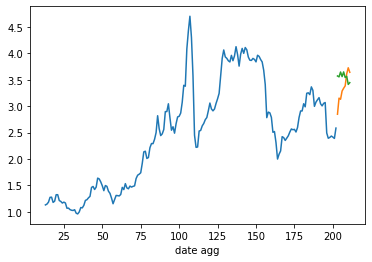

In [124]:
prediction = pd.DataFrame()
prediction['date agg'] = y_test.index
prediction['fuel price'] = pred
prediction.set_index('date agg', inplace=True)
train['fuel price'].plot()
test['fuel price'].plot()
prediction['fuel price'].plot()

ONLY CONSIDERING UNEMPLOYMENT AND BRENT

In [128]:
X_train, y_train = train[['year', 'month', 'day', 'weekday','unemp lag 1',	'brent lag 1']], train[['fuel price']]
X_test, y_test = test[['year', 'month', 'day', 'weekday','unemp lag 1',	'brent lag 1']], test[['fuel price']]
clf =  LinearRegression()
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

mse = mean_squared_error(test['fuel price'], pred)
rmse = mean_squared_error(test['fuel price'], pred, squared=False)
mape = mean_absolute_percentage_error(test['fuel price'], pred)
table = pd.DataFrame({'MSE':[mse], 'RMSE':[rmse], 'MAPE':[mape]})
table

,MSE,RMSE,MAPE
0,0.02045,0.143004,0.029962


<AxesSubplot:xlabel='date agg'>

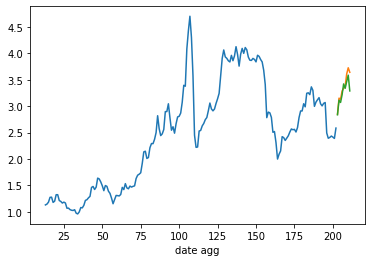

In [126]:
prediction = pd.DataFrame()
prediction['date agg'] = y_test.index
prediction['fuel price'] = pred
prediction.set_index('date agg', inplace=True)
train['fuel price'].plot()
test['fuel price'].plot()
prediction['fuel price'].plot()

ONLY CONSIDERING UNEMPLOYMENT AND BRENT AND MA

In [135]:
X_train, y_train = train[['year', 'month', 'day', 'weekday','unemp lag 1',	'brent lag 1',	'MA(7) laged']], train[['fuel price']]
X_test, y_test = test[['year', 'month', 'day', 'weekday','unemp lag 1',	'brent lag 1',	'MA(7) laged']], test[['fuel price']]
clf =  LinearRegression()
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

mse = mean_squared_error(test['fuel price'], pred)
rmse = mean_squared_error(test['fuel price'], pred, squared=False)
mape = mean_absolute_percentage_error(test['fuel price'], pred)
table = pd.DataFrame({'MSE':[mse], 'RMSE':[rmse], 'MAPE':[mape]})
table

,MSE,RMSE,MAPE
0,0.025353,0.159228,0.035124


<AxesSubplot:xlabel='date agg'>

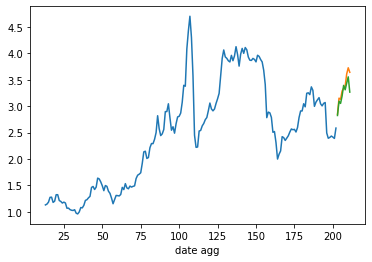

In [136]:
prediction = pd.DataFrame()
prediction['date agg'] = y_test.index
prediction['fuel price'] = pred
prediction.set_index('date agg', inplace=True)
train['fuel price'].plot()
test['fuel price'].plot()
prediction['fuel price'].plot()

ONLY CONSIDERING MA

In [133]:
X_train, y_train = train[['year', 'month', 'day', 'weekday',	'MA(7) laged']], train[['fuel price']]
X_test, y_test = test[['year', 'month', 'day', 'weekday',	'MA(7) laged']], test[['fuel price']]
clf =  LinearRegression()
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

mse = mean_squared_error(test['fuel price'], pred)
rmse = mean_squared_error(test['fuel price'], pred, squared=False)
mape = mean_absolute_percentage_error(test['fuel price'], pred)
table = pd.DataFrame({'MSE':[mse], 'RMSE':[rmse], 'MAPE':[mape]})
table

,MSE,RMSE,MAPE
0,0.334345,0.578226,0.142748


<AxesSubplot:xlabel='date agg'>

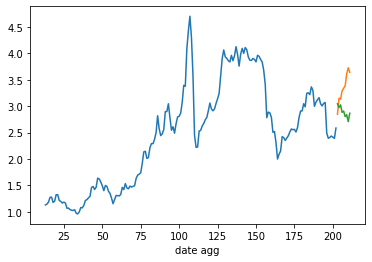

In [134]:
prediction = pd.DataFrame()
prediction['date agg'] = y_test.index
prediction['fuel price'] = pred
prediction.set_index('date agg', inplace=True)
train['fuel price'].plot()
test['fuel price'].plot()
prediction['fuel price'].plot()

In [120]:
pred

array([[2.7197562 ],
       [2.99819006],
       [2.98792028],
       [3.15010752],
       [3.33948898],
       [3.31401689],
       [3.45826438],
       [3.58073883],
       [3.34954756]])

In [122]:
pred = test[['MA(7) laged']]
mse = mean_squared_error(test['fuel price'], pred)
rmse = mean_squared_error(test['fuel price'], pred, squared=False)
mape = mean_absolute_percentage_error(test['fuel price'], pred)
table = pd.DataFrame({'MSE':[mse], 'RMSE':[rmse], 'MAPE':[mape]})
table

,MSE,RMSE,MAPE
0,0.645336,0.803328,0.204552
